In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

In [2]:
"""
http://grouplens.org/datasets/movielens/100k/

u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of 
              user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC   

u.info     -- The number of users, items, and ratings in the u data set.

u.item     -- Information about the items (movies); this is a tab separated
              list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.

u.genre    -- A list of the genres.

u.user     -- Demographic information about the users; this is a tab
              separated list of
              user id | age | gender | occupation | zip code
              The user ids are the ones used in the u.data data set.
"""
print('Readme')

Readme


In [3]:
r_cols = ['user_id', 'movie_id', 'rating']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols, usecols=range(3), encoding='latin-1')
ratings.head()

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
user_id     100000 non-null int64
movie_id    100000 non-null int64
rating      100000 non-null int64
dtypes: int64(3)
memory usage: 2.3 MB


# Matrix Factorization

In [5]:
R = ratings.sample(frac=0.01)

user_dummy = pd.get_dummies(R['user_id'])
R = pd.concat([R, user_dummy], axis=1)
movie_dummy = pd.get_dummies(R['movie_id'])
R = pd.concat([R, movie_dummy], axis=1)

y = R['rating'].values
X = R.drop(['user_id','movie_id' ,'rating'], axis=1).values

In [6]:
# Normalization
X = (X - np.min(X))/(np.max(X) - np.min(X))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

In [8]:
def FM_2way(X_data, y_data, alpha, beta1, beta2, K, num_epoch):
    X_data = (X_data-np.min(X_data))/(np.max(X_data)-np.min(X_data))
    w0 = np.random.normal(0,0.1,1)
    w = np.random.normal(0,0.1,size= X_data.shape[1])
    V = np.random.normal(0,0.1,size=(X_data.shape[1],K))
    L = []
    print(f'X:{X_data.shape}, y:{y_data.shape}')
    print(f'w0:{w0.shape}, w:{w.shape}, V:{V.shape}')
    batch_size = 100
       
    for epoch in range(num_epoch):
        if epoch % 500 == 0:
            print(f'epoch: {epoch}/{num_epoch}')
        for batch in range(len(X_train)//batch_size):
            X = X_data[batch*batch_size:(batch+1)*batch_size,:]
            y = y_data[batch*batch_size:(batch+1)*batch_size]
            

            # Prediction y_hat 
            # Interaction between two variables
            tmp = np.sum(np.dot(X,V)**2, axis=1)
            tmp2 = np.sum(np.dot(X**2,V**2), axis=1)
            interactions = tmp - tmp2

            y_hat = w0 + np.dot(X,w) + 0.5*interactions
         
            # Loss with L1 regularization
            e = y_hat - y
            loss = np.sum(e**2)/len(y) + beta1*np.abs(w0) + beta1*np.sum(np.abs(w)) + beta2*np.sum(np.abs(V))
            L.append(loss[0]) 
            #print(loss, y_hat.shape, y.shape)
            
            # Gradient Descent
            w0 -= alpha*(2*np.sum(e)/len(y) + beta1*np.sign(w0))
            w -= alpha*(2*np.dot(e,X)/len(y) + beta1*np.sign(w))
            
            #for k in range(V.shape[0]):
            #    for f in range(V.shape[1]):
            #        V[k,f] -= alpha*(2*np.sum(e*X[:,k]*np.dot(X,V[:,f])-V[k,f]*X[:,k]**2)/len(y)+beta2*np.sign(V[k,f]))
            for f in range(V.shape[1]):
                V[:,f] = np.sum((e*X.T*np.dot(X,V[:,f])).T-V[:,f]*X**2, axis=0)
     
        #print(f'w0:{w0.shape}, w:{w.shape}, V:{V.shape}')        

    return w0, w, V, L

def prediction(X, w0, w, V):

    tmp = np.sum(np.dot(X,V)**2, axis=1)
    tmp2 = np.sum(np.dot(X**2,V**2), axis=1)
    interactions = tmp - tmp2

    y_hat = w0 + np.dot(X,w) + 0.5*interactions
    
    return y_hat  

def RMSE(y, y_hat):
    return np.sqrt(np.sum((y-y_hat)**2)/len(y))

In [16]:
w0, w, V, L = FM_2way(X_train, y_train, 0.5, 0, 0, 2, 1500)

X:(700, 1068), y:(700,)
w0:(1,), w:(1068,), V:(1068, 2)
epoch: 0/1500
epoch: 500/1500
epoch: 1000/1500


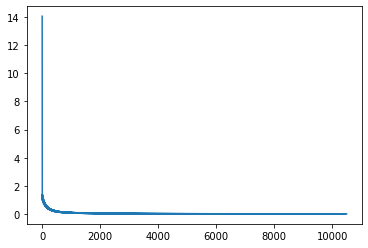

In [17]:
plt.plot(L)

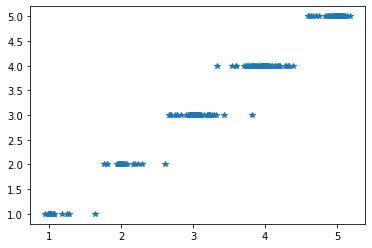

0.09775087745966837


In [18]:
y_hat = prediction(X_train, w0, w, V)
plt.plot(y_hat, y_train,'*')
plt.show()
print(RMSE(y_train, y_hat))

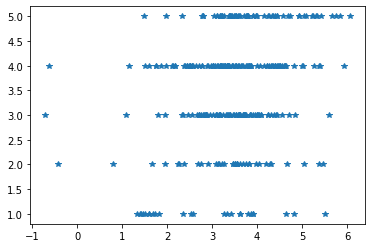

1.3753978695608353


In [19]:
y_pred = prediction(X_test, w0, w, V)
plt.plot(y_pred, y_test,'*')
plt.show()
print(RMSE(y_test, y_pred))

In [13]:
clf = SVR(C=1.0, kernel='poly', degree=2, gamma=2)
clf.fit(X_train,y_train)
y_hat1 = clf.predict(X_train)

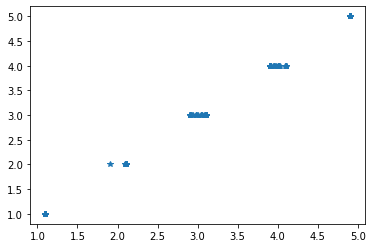

0.09833941489459079


In [14]:
plt.plot(y_hat1, y_train,'*')
plt.show()
print(RMSE(y_train, y_hat1))

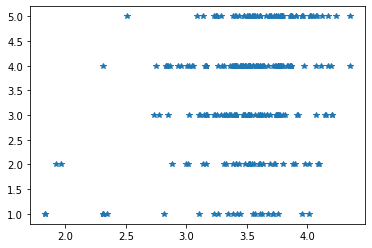

1.1401309451537498


In [15]:
y_pred1 = clf.predict(X_test)
plt.plot(y_pred1, y_test,'*')
plt.show()
print(RMSE(y_test, y_pred1))

## Conclusion

The reference paper, Factorization Machines written by Steffen Rendle, introduced that FMs allow parameter updates under very sparse data where SVMs fail. However, I didn't get the expected result because of using sample data which is not very sparse data. Thus the two models are well-trained in this practice.